In [4]:
# Import packages
import re
import sys
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree, svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
import time
import graphviz
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean, std
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def pretty_print(output: str):
    """
    pretty_print formats the print statement a bit nicer
    :param output: Output to format
    :return:
    """
    print(f'********** {output} **********\n')

In [7]:
def investigate(df: pd.DataFrame):
    """
    investigate prints out important detail about the dataframe
    Prints out the shape of the dataframe
    Prints out the amount of null cells in the dataframe
    Prints out a description of the dataframe (Count, unique values)
    Prints out information about the dataframe (Number of entries, column names and non-null count)

    :param df: Dataframe to investigate
    :return:
    """
    pretty_print('Shape')
    print(df.shape)
    print()

    pretty_print('Number of null values')
    print(df.isnull().sum())
    print()

    pretty_print('Description of dataframe')
    print(df.describe())
    print()

    pretty_print('Information about dataframe')
    print(df.info())
    print()

In [8]:
def clean_data(reviews: list) -> list:
    """
    clean_data iterates over the reviews, removes html tags, removes punctuation, lowers all capital letters, removes
    stop words and stems the remaining words
    :param reviews: reviews to clean
    :return: returns the cleaned list
    """
    nltk.download('stopwords')
    ps = PorterStemmer()
    corpus = []

    for review in reviews:
        review_val = re.sub('<.*?>', " ", review)
        review_val = re.sub("[^a-zA-Z]", " ", review_val)
        review_val = review_val.lower()
        review_val = review_val.split()
        review_val = [ps.stem(word) for word in review_val if word not in set(stopwords.words('english'))]
        review_val = ' '.join(review_val)
        corpus.append(review_val)

    return corpus

In [9]:
def remove_html_tags(reviews: list) -> list:
    """
    remove_html_tags removes the html tags from the review and lowers all capital letters
    :param reviews: reviews to clean
    :return: returns the list of reviews
    """
    corpus = []

    for review in reviews:
        review_val = re.sub('<.*?>', " ", review)
        review_val = review_val.lower()
        corpus.append(review_val)

    return corpus

In [10]:
def vectorise_data(corpus, save_data=False):
    """
    vectorise_data turns the words into a numerical representation
    :param corpus: List to vectorise
    :param save_data: Option to save the vectorised representation to a text file
    :return:
    """
    cv = TfidfVectorizer(max_features=5000)
    data = cv.fit_transform(corpus).toarray()

    if save_data:
        np.savetxt('vectorised_data', data)

    return data


In [11]:
def print_train_test_shapes(x_train_param, x_test_param, y_train_param, y_test_param):
    """
    print_train_test_shapes prints the shape of each parameter
    :param x_train_param: Review data to train
    :param x_test_param: Review data to test
    :param y_train_param: Sentiment data to train
    :param y_test_param: Sentiment data to test
    :return:
    """
    pretty_print('Train and test shapes for x and y')
    print(x_train_param.shape)
    print(x_test_param.shape)
    print(y_train_param.shape)
    print(y_test_param.shape)


In [12]:
def output_timings(start, fit, predict):
    """
    output_timings prints out the time taken to fit the model and predict the output
    :param start: Time when the function started
    :param fit: Time after the fitting of model had completed
    :param predict: Time after the prediction had been completed
    :return:
    """
    fit_timing = fit - start
    prediction_timing = predict - fit

    fit_timing_output = f'Time taken to fit the model: {fit_timing} seconds'
    prediction_timing_output = f'Time taken to predict the output: {prediction_timing} seconds'

    print()
    pretty_print(fit_timing_output)
    pretty_print(prediction_timing_output)

In [13]:
def output_predictions(model: str, predictions, y_test_param):
    """
    output_predictions prints out the accuracy score, the confustion matrix and the classification report of the model
    that has been created
    :param model: Model that has been created
    :param predictions: The predictions that were made with the model
    :param y_test_param: The sentiment test values
    :return:
    """
    print('\n\n')
    pretty_print(f'{model} Predictions')

    print(accuracy_score(y_test_param, predictions))

    cm = confusion_matrix(y_test_param, predictions)
    print(cm)
    sns.set()
    ax = sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=['positive', 'negative'],
                     yticklabels=['positive', 'negative'])
    plt.show(block=True)

    print(classification_report(y_test_param, predictions))

In [14]:
def one_hot_encoder(arr):
    """
    one_hot_encoder converts the text representation of the sentiment to binary integer values
    :param arr: Array to be encoded
    :return: The encoded array
    """
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(arr)

    return integer_encoded


In [15]:
def cross_validation(model, x, y):
    """
    cross_validation runs the accuracy calculation 10 times and computes the average
    :param model: Model to compute
    :param x: Review test values
    :param y: Sentiment test values
    :return:
    """
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=1)
    pretty_print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [16]:
def run_naive_bayes(x_train_param, x_test_param, y_train_param, y_test_param):
    """
    run_naive_bayes creates, fits and predicts the Multinomial Naive Bayes model
    Timing of the fitting and predicting process also occurs
    Data is sent to the output_predictions and output_timings functions
    :param x_train_param: Review data to train
    :param x_test_param: Review data to test
    :param y_train_param: Sentiment data to train
    :param y_test_param: Sentiment data to test
    :return:
    """
    pretty_print("Creating Naive Bayes model")
    mnb = MultinomialNB()

    pretty_print("Fitting model")
    start = time.time()
    mnb.fit(x_train_param, y_train_param)
    fitting_time = time.time()

    pretty_print("Predicting test data")
    pred = mnb.predict(x_test_param)

    prediction_time = time.time()

    output_predictions('Naive Bayes', pred, y_test_param)
    output_timings(start, fitting_time, prediction_time)

    pretty_print("Cross validating")
    cross_validation(mnb, x_test_param, y_test_param)

In [17]:
def run_decision_tree(x_train_param, x_test_param, y_train_param, y_test_param):
    """
    run_decision_tree creates, fits and predicts the Decision Tree model
    Timing of the fitting and predicting process also occurs
    Data is sent to the output_predictions and output_timings functions
    :param x_train_param: Review data to train
    :param x_test_param: Review data to test
    :param y_train_param: Sentiment data to train
    :param y_test_param: Sentiment data to test
    :return:
    """
    pretty_print("Creating Decision Tree model")
    clf = tree.DecisionTreeClassifier()

    pretty_print("Fitting model")
    start = time.time()
    clf = clf.fit(x_train_param, y_train_param)
    fitting_time = time.time()

    pretty_print("Predicting test data")
    pred = clf.predict(x_test_param)
    prediction_time = time.time()

    pretty_print("Plotting tree")
    tree.plot_tree(clf)
    dot_data = tree.export_graphviz(clf, out_file=None, max_depth=3, class_names=['positive', 'negative'])
    graph = graphviz.Source(dot_data)
    graph.render("test")

    output_predictions('Decision Tree', pred, y_test_param)
    output_timings(start, fitting_time, prediction_time)

    pretty_print("Cross validating")
    cross_validation(clf, x_test_param, y_test_param)

In [18]:
def run_support_vector_machine(x_train_param, x_test_param, y_train_param, y_test_param):
    """
    run_support_vector_machine creates, fits and predicts the Support Vector Machine model
    Timing of the fitting and predicting process also occurs
    Data is sent to the output_predictions and output_timings functions
    :param x_train_param: Review data to train
    :param x_test_param: Review data to test
    :param y_train_param: Sentiment data to train
    :param y_test_param: Sentiment data to test
    :return:
    """
    pretty_print("Creating Support Vector Machine model")
    clf = svm.SVC()

    pretty_print("Fitting model")
    start = time.time()
    clf.fit(x_train_param, y_train_param)
    fitting_time = time.time()

    pretty_print("Predicting test data")
    pred = clf.predict(x_test_param)
    prediction_time = time.time()

    output_predictions('Support Vector Machine', pred, y_test_param)
    output_timings(start, fitting_time, prediction_time)

    pretty_print("Cross validating")
    cross_validation(clf, x_test_param, y_test_param)

In [19]:
def run_logistic_regression(x_train_param, x_test_param, y_train_param, y_test_param):
    """
    run_logistic_regression creates, fits and predicts the Logistic Regression model
    Timing of the fitting and predicting process also occurs
    Data is sent to the output_predictions and output_timings functions
    :param x_train_param: Review data to train
    :param x_test_param: Review data to test
    :param y_train_param: Sentiment data to train
    :param y_test_param: Sentiment data to test
    :return:
    """
    pretty_print("Creating Logistic Regression model")
    clf = LogisticRegression(random_state=1, max_iter=1500, solver='saga')

    pretty_print("Fitting model")
    start = time.time()
    clf.fit(x_train_param, y_train_param)
    fitting_time = time.time()

    pretty_print("Predicting test data")
    pred = clf.predict(x_test_param)
    prediction_time = time.time()

    output_predictions('Logistic Regression', pred, y_test_param)
    output_timings(start, fitting_time, prediction_time)

    pretty_print("Cross validating")
    cross_validation(clf, x_test_param, y_test_param)

In [20]:
def run_mlp(x_train_param, x_test_param, y_train_param, y_test_param):
    """
    run_mlp creates, fits and predicts the Multi-layer Perceptron model
    Timing of the fitting and predicting process also occurs
    Data is sent to the output_predictions and output_timings functions
    :param x_train_param: Review data to train
    :param x_test_param: Review data to test
    :param y_train_param: Sentiment data to train
    :param y_test_param: Sentiment data to test
    :return:
    """
    pretty_print("Creating Multi-layer Perceptron model")
    clf = MLPClassifier(solver='adam', activation='logistic', alpha=1e-5, hidden_layer_sizes=(16, 16),
                        random_state=1, max_iter=200, verbose=False, early_stopping=True)

    pretty_print("Fitting model")
    start = time.time()
    clf.fit(x_train_param, y_train_param)
    fitting_time = time.time()

    pretty_print("Predicting test data")
    pred = clf.predict(x_test_param)
    prediction_time = time.time()

    output_predictions('Machine learning classification', pred, y_test_param)
    output_timings(start, fitting_time, prediction_time)

    pretty_print("Cross validating")
    cross_validation(clf, x_test_param, y_test_param)

In [21]:
def generate_data(clean_level: int = 0) -> (list, list, list, list):
    """
    generate_data reads in the data from the csv and passes it to the investigate function
    If the clean_level parameter is 0, no cleaning will be done to the data
    If the clean_level parameter is 1, only html tags will be removed
    If the clean_level parameter is 2, the data will be cleaned using the clean_data function
    The reviews are vectorised
    The sentiments are one hot encoded
    The test and train data are split into a 70/30 split with a random state of 87 to allow for reproducible tests
    The shapes of the split data are printed out
    :param clean_level: The level of cleaning to be done to the data
    :return: The test and train data
    """
    pretty_print("Reading csv")
    df = pd.read_csv('IMDB Dataset.csv')
    investigate(df)

    reviews, sentiments = df['review'], df['sentiment']

    if clean_level == 0:
        pretty_print("Data will not be cleaned")
    elif clean_level == 1:
        pretty_print("Removing html tags")
        corpus = remove_html_tags(reviews)
    elif clean_level == 2:
        pretty_print("Cleaning data")
        corpus = clean_data(reviews)
    else:
        sys.exit("Invalid clean level option")

    if clean_level == 0:
        pretty_print("Vectorising review data")
        vectorised_data = vectorise_data(reviews)
    else:
        pretty_print("Vectorising review data")
        vectorised_data = vectorise_data(corpus)

    pretty_print("Encoding sentiment data")
    sentiments = one_hot_encoder(sentiments)

    pretty_print("Splitting data")
    x_train, x_test, y_train, y_test = train_test_split(vectorised_data, sentiments, train_size=0.7, random_state=87)

    print_train_test_shapes(x_train, x_test, y_train, y_test)

    return x_train, x_test, y_train, y_test

In [23]:
x_train, x_test, y_train, y_test = generate_data(0)

********** Reading csv **********

********** Shape **********

(50000, 2)

********** Number of null values **********

review       0
sentiment    0
dtype: int64

********** Description of dataframe **********

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

********** Information about dataframe **********

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

********** Data will not be cleaned **********

********** Vectorising review data 

********** Creating Naive Bayes model **********

********** Fitting model **********

********** Predicting test data **********




********** Naive Bayes Predictions **********

0.8542
[[6390 1088]
 [1099 6423]]


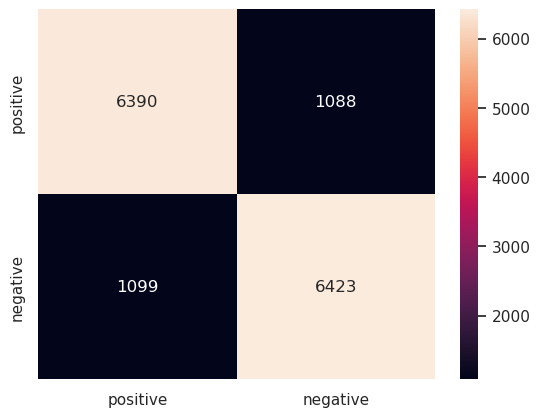

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      7478
           1       0.86      0.85      0.85      7522

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000


********** Time taken to fit the model: 0.1669013500213623 seconds **********

********** Time taken to predict the output: 0.046031951904296875 seconds **********

********** Cross validating **********

Accuracy: 0.850 (0.008)


In [24]:
run_naive_bayes(x_train, x_test, y_train, y_test)

********** Creating Decision Tree model **********

********** Fitting model **********

********** Predicting test data **********

********** Plotting tree **********




********** Decision Tree Predictions **********

0.7110666666666666
[[5376 2102]
 [2232 5290]]


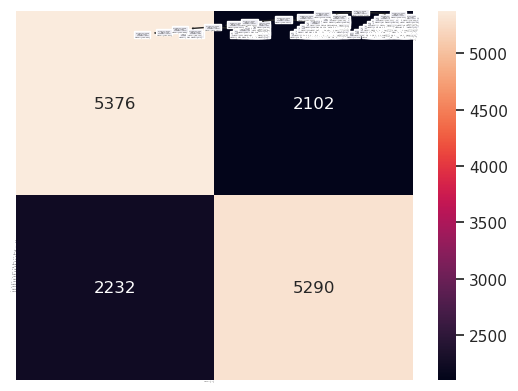

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      7478
           1       0.72      0.70      0.71      7522

    accuracy                           0.71     15000
   macro avg       0.71      0.71      0.71     15000
weighted avg       0.71      0.71      0.71     15000


********** Time taken to fit the model: 53.98405575752258 seconds **********

********** Time taken to predict the output: 0.09721899032592773 seconds **********

********** Cross validating **********

Accuracy: 0.696 (0.011)


In [25]:
run_decision_tree(x_train, x_test, y_train, y_test)

In [ ]:
# Note: This takes over 3 hours to run!
run_support_vector_machine(x_train, x_test, y_train, y_test)

********** Creating Logistic Regression model **********

********** Fitting model **********

********** Predicting test data **********




********** Logistic Regression Predictions **********

0.8911333333333333
[[6589  889]
 [ 744 6778]]


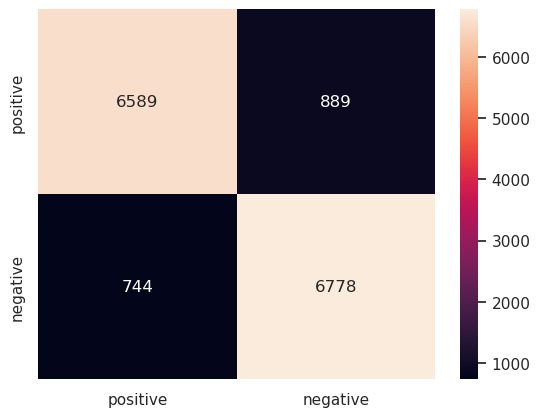

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7478
           1       0.88      0.90      0.89      7522

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000


********** Time taken to fit the model: 16.494606256484985 seconds **********

********** Time taken to predict the output: 0.039809465408325195 seconds **********

********** Cross validating **********

Accuracy: 0.878 (0.009)


In [26]:
run_logistic_regression(x_train, x_test, y_train, y_test)

********** Creating Multi-layer Perceptron model **********

********** Fitting model **********

********** Predicting test data **********




********** Machine learning classification Predictions **********

0.8958
[[6749  729]
 [ 834 6688]]


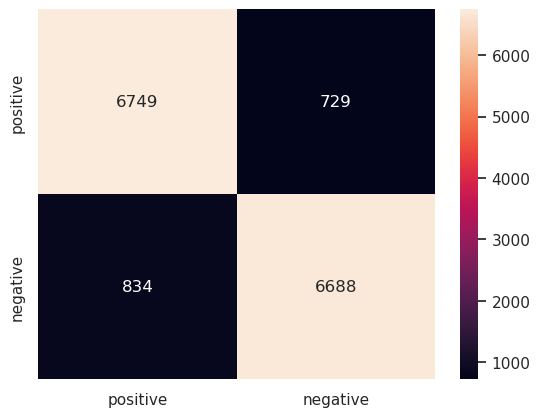

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      7478
           1       0.90      0.89      0.90      7522

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000


********** Time taken to fit the model: 14.827693939208984 seconds **********

********** Time taken to predict the output: 0.05328035354614258 seconds **********

********** Cross validating **********

Accuracy: 0.885 (0.010)


In [27]:
run_mlp(x_train, x_test, y_train, y_test)